# ML HW3


In [1]:
import os

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from scipy.stats import multivariate_normal
from sklearn import svm

## 1. Support Vector Machine


In [2]:
data = pd.read_csv('./x_train.csv', header=None) / 255.0
data = np.array(data)
data = data - np.mean(data, axis=0)

label = pd.read_csv('./t_train.csv', header=None)
label = np.array(label).reshape(-1)


### Principal Component Analysis (PCA)


In [3]:
class PCA:
    eigenvalues: np.ndarray
    eigenvectors: np.ndarray

    def __init__(self, n_components) -> None:
        self.n_components = n_components

    def fit(self, x):
        """
        Args:
            x: (n_samples, n_features)
        Returns:
            self
        """
        u, s, vh = np.linalg.svd(x, full_matrices=False)
        self.eigenvalues = np.square(s) / (x.shape[0] - 1)
        self.eigenvectors = vh.T[:, :self.n_components]
        return self

    def transform(self, x):
        """
        Args:
            x: (n_samples, n_features)
        Returns:
            (n_samples, n_components)
        """
        return x @ self.eigenvectors

    def fit_transform(self, x):
        return self.fit(x).transform(x)

    def components(self):
        """
        Returns:
            (n_components, n_features)
        """
        return self.eigenvectors.T

    def explained_variance(self):
        return self.eigenvalues[:self.n_components]

    def explained_variance_ratio(self):
        return self.eigenvalues[:self.n_components] / np.sum(self.eigenvalues)

In [4]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(data)
print(pca_data.shape)

(300, 2)


### Decision Approaches

1. one-vs-one

   Choose two classes each time, and train a binary classifier for each pair of classes. Then, for a new sample, we can use the binary classifiers to predict the class of the sample. Finally, we can choose the class that has the most votes.

2. one-vs-rest

   Choose one class as the positive class, and the rest as the negative class. Then, we can train a binary classifier for each class. Finally, we can choose the class that has the most votes.

In this case, both approaches will train three binary classifiers. Here. I will use **one-vs-one** approach because it use only two classes of data each time, and it is more efficient than one-vs-rest approach.


### Support Vector Machine (SVM)


In [5]:
from typing import Literal


class Kernel:

    def __init__(self, mode: Literal['Linear', 'Polynomial']) -> None:
        if mode not in ['Linear', 'Polynomial']:
            raise ValueError(f'Unknown mode: {mode}, should be `Linear` or `Polynomial`')

        self.mode = mode

    def phi(self, x: np.ndarray):
        if self.mode == 'Linear':
            return x
        else:  # self.mode == 'Polynomial':
            return np.array([
                np.square(x[..., 0]),
                np.sqrt(2) * x[..., 0] * x[..., 1],
                np.square(x[..., 1]),
            ]).T

    def compute_kernel(self, x1, x2):
        return self.phi(x1) @ self.phi(x2).T


In [6]:
class SVM:
    coef: np.ndarray
    sv_idx: np.ndarray
    weight: np.ndarray
    bias: np.floating

    def __init__(self, pos_cls, neg_cls, kernel: Kernel, C=1.0) -> None:
        self.kernel = kernel
        self.C = C
        self.pos_cls = pos_cls
        self.neg_cls = neg_cls

    def compute_weight_and_bias(self, alpha, x, t):
        weight = (alpha * t).T @ self.kernel.phi(x)

        m_idx = np.logical_and(self.C > alpha, alpha > 0)
        s_idx = alpha > 0

        kernels = self.kernel.compute_kernel(x[m_idx], x[s_idx])
        bias = np.mean(t[m_idx] - kernels @ (alpha * t)[s_idx])

        return weight, bias

    def fit(self, x, t):
        t = np.where(t == self.pos_cls, 1.0, -1.0)

        from sklearn.svm import SVC
        if self.kernel.mode == 'Linear':
            clf = SVC(kernel='linear', C=self.C, decision_function_shape='ovo')
        else:  # self.kernel.mode == 'Polynomial'
            clf = SVC(kernel='poly', C=self.C, degree=2, decision_function_shape='ovo')
        clf.fit(x, t)

        self.coef = np.abs(clf.dual_coef_).reshape(-1)
        self.sv_idx = clf.support_

        alpha = np.zeros_like(t)
        alpha[self.sv_idx] = self.coef
        self.weight, self.bias = self.compute_weight_and_bias(alpha, x, t)

        return self

    def predict(self, x):
        pred = np.sign(self.kernel.phi(x) @ self.weight.T + self.bias)
        return np.where(pred == 1.0, self.pos_cls, self.neg_cls)


In [7]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy


def plot(x, y, sv_idx, xx, yy, pred, title):
    c1_idx = np.where(y == 0)
    c2_idx = np.where(y == 1)
    c3_idx = np.where(y == 2)
    plt.figure()
    plt.title(title)
    plt.scatter(x[sv_idx, 0],
                x[sv_idx, 1],
                s=100,
                facecolors='none',
                edgecolors='k',
                label='Support Vector')
    plt.scatter(x[c1_idx, 0], x[c1_idx, 1], c='b', marker='x', label='T-shirt/top')
    plt.scatter(x[c2_idx, 0], x[c2_idx, 1], c='r', marker='x', label='Trouser')
    plt.scatter(x[c3_idx, 0], x[c3_idx, 1], c='g', marker='x', label='Sandal')
    plt.contourf(xx, yy, pred, alpha=0.2, cmap=plt.cm.brg)
    plt.legend()
    plt.show()


def vote(y):
    classes = np.arange(3)
    counts = np.empty((*(y.shape[:-1]), 3))
    for cls in classes:
        counts[..., cls] = np.sum(y == cls, axis=-1)

    return np.argmax(counts, axis=-1)


#### Linear SVM

In [8]:
linear_kernel = Kernel(mode='Linear')
C = 1.0
linear_svm = []

for c1, c2 in [[0, 1], [0, 2], [1, 2]]:
    idx = np.logical_or(label == c1, label == c2)
    x = pca_data[idx]
    y = label[idx]
    svm = SVM(c1, c2, linear_kernel, C=C).fit(x, y)
    linear_svm.append(svm)

    print(f'Class {c1} vs Class {c2}')
    print(f'Number of support vectors: {len(svm.sv_idx)}')
    print(f'Accuracy: {np.mean(svm.predict(x) == y)}')
    print()


Class 0 vs Class 1
Number of support vectors: 30
Accuracy: 0.94

Class 0 vs Class 2
Number of support vectors: 11
Accuracy: 0.985

Class 1 vs Class 2
Number of support vectors: 3
Accuracy: 1.0



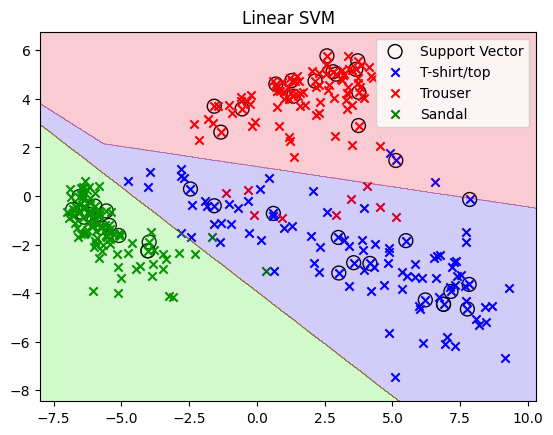

In [9]:
sv_idx = np.concatenate([svm.sv_idx for svm in linear_svm])

xx, yy = make_meshgrid(pca_data[:, 0], pca_data[:, 1])

grid_data = np.stack([xx.ravel(), yy.ravel()], axis=-1)
pred = np.empty((xx.shape[0], xx.shape[1], len(linear_svm)))
for i, svm in enumerate(linear_svm):
    pred[..., i] = svm.predict(grid_data).reshape(xx.shape)

pred = vote(pred)

plot(pca_data, label, sv_idx, xx, yy, pred, 'Linear SVM')

#### Polynomial SVM

In [10]:
poly_kernel = Kernel(mode='Polynomial')
C = 1.0
poly_svm = []

for c1, c2 in [[0, 1], [0, 2], [1, 2]]:
    idx = np.logical_or(label == c1, label == c2)
    x = pca_data[idx]
    y = label[idx]
    svm = SVM(c1, c2, poly_kernel, C=C).fit(x, y)
    poly_svm.append(svm)

    print(f'Class {c1} vs Class {c2}')
    print(f'Number of support vectors: {len(svm.sv_idx)}')
    print(f'Accuracy: {np.mean(svm.predict(x) == y)}')
    print()


Class 0 vs Class 1
Number of support vectors: 65
Accuracy: 0.825

Class 0 vs Class 2
Number of support vectors: 43
Accuracy: 0.95

Class 1 vs Class 2
Number of support vectors: 49
Accuracy: 0.925



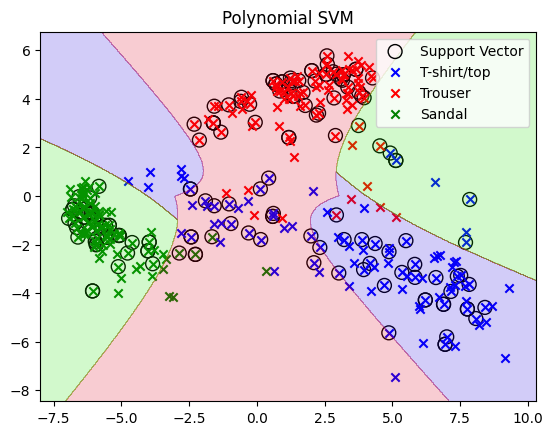

In [11]:
sv_idx = np.concatenate([svm.sv_idx for svm in poly_svm])

xx, yy = make_meshgrid(pca_data[:, 0], pca_data[:, 1])

grid_data = np.stack([xx.ravel(), yy.ravel()], axis=-1)
pred = np.empty((xx.shape[0], xx.shape[1], len(poly_svm)))
for i, svm in enumerate(poly_svm):
    pred[..., i] = svm.predict(grid_data).reshape(xx.shape)

pred = vote(pred)

plot(pca_data, label, sv_idx, xx, yy, pred, 'Polynomial SVM')

## 2. Gaussian Mixture Model


In [12]:
with Image.open("./hw3.jpg") as img:
    image = np.array(img)

In [13]:
class KMeans:
    means: np.ndarray
    idicators: np.ndarray
    dtype = None

    def __init__(self, k, max_iter=100):
        self.k = k
        self.max_iter = max_iter

    def fit(self, x):
        self.dtype = x.dtype
        self.means = x[np.random.choice(x.shape[0], self.k, replace=False)]
        self.indicators = np.zeros((x.shape[0], self.k), dtype=np.int8)

        for _ in range(self.max_iter):
            dist_2 = np.linalg.norm(x[:, None] - self.means, ord=2, axis=-1)**2
            self.indicators = (dist_2 == np.min(dist_2, axis=-1, keepdims=True))

            num_points = np.sum(self.indicators[..., None], axis=0)
            self.means = np.sum(x[:, None] * self.indicators[..., None], axis=0) / num_points
        return self

    def predict(self, x):
        dist_2 = np.linalg.norm(x[:, None] - self.means, ord=2, axis=-1)**2
        return np.argmin(dist_2, axis=-1)

    def get_means(self):
        return self.means.astype(self.dtype)